# iCAT world
---

#### Overview
Notebook to create stacks of tile specifications in "real-world" or "physical" coordinate space (aka microns). This is to facilitate `5_iCAT-correlate.ipynb` as there is otherwise no way of knowing _a priori_ which high-mag EM tiles overlap with each low-mag EM tile.

#### Packages

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import renderapi
import icatapi

/home/skaracoban/miniconda3/envs/icat/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_2611136/3083622315.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Settings

In [2]:
# pandas display settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 15)

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Set up environment
---

In [3]:
# `render` project parameters
# ---------------------------
owner = 'skaracoban'
project = '20240530_SK001'

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'http://localhost',
    'port': 8081,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://localhost',
 'port': 8081,
 'owner': 'skaracoban',
 'project': '20240530_SK001',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

In [4]:
# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render, **render_connect_params)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]

# Output
# ------
out = f"""\
all stacks.......... {stacks}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
stacks = ['EM_lomag', 'EM_himag']
df_project = icatapi.create_stacks_DataFrame(stacks=stacks,
                                             render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(1))

all stacks.......... ['EM_lomag_overlaid', 'exc_470nm_overlaid', 'EM_himag_montaged', 'EM_minimontages', 'EM_lomag_world', 'EM_himag_world', 'EM_lomag', 'exc_470nm', 'EM_himag', 'EM_himag_stitched_filtered', 'EM_himag_stitched']
EM stacks........... ['EM_lomag_overlaid', 'EM_himag_montaged', 'EM_minimontages', 'EM_lomag_world', 'EM_himag_world', 'EM_lomag', 'EM_himag', 'EM_himag_stitched_filtered', 'EM_himag_stitched']
FM stacks........... ['exc_470nm_overlaid', 'exc_470nm']
...



/tmp/ipykernel_2611136/2852230622.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1))


,,tileId,z,width,height,minint,maxint,imagePyramid,tforms,stack,sectionId,temca,camera,imageRow,imageCol,stageX,stageY,pixelsize
stack,,,,,,,,,,,,,,,,,,
EM_himag,235,t088_z1_y4_x7,1.0,4096.0,4096.0,31528.0,34283.0,"[0, 1, 2, 3...",[M=[[1.0000...,EM_himag,S002,SECOM,pcie-6251,4,7,-6921.087419,1376.074882,0.004889
EM_lomag,2,t0_z2_y0_x0,2.0,4096.0,4096.0,31383.0,35714.0,"[0, 1, 2, 3...",[M=[[1.0000...,EM_lomag,S003,SECOM,pcie-6251,0,0,-7313.204806,1328.582691,0.036682


In [5]:
# lower stageX by 200 for the low-mag stack
df_project.loc[df_project['stack'] == 'EM_lomag', 'stageX'] -= 200
df_project.loc[df_project['stack'] == 'EM_lomag', 'stageY'] -= 200

## Create world stacks
---

In [6]:
from matplotlib.transforms import Affine2D as AffineMPL
from renderapi.transform import AffineModel as AffineRender

from icatapi.overlay import get_transform_metadata

In [7]:
channel_map = {
    'EM_lomag': 'Secondary electrons',
    'EM_himag': 'Secondary electrons'
}
not_good = False
if not_good:
    extra_translation = {
        'EM_lomag': [-210, -100],
        'EM_himag': [0, 0]
    }

# Loop through stacks
for stack, df_stack in tqdm(df_project.groupby('stack')):
    if (df_stack["stack"] == 'EM_lomag').any():
        pass
    # Loop through tiles
    for i, tile in df_stack.iterrows():
        # Get transform metadata
        try:
            fp = Path(tile['imagePyramid'][0].imageUrl.split('.nl')[1])
        except IndexError:
            fp = Path(tile['imagePyramid'][0].imageUrl)
        tform_md = get_transform_metadata(fp)
        channel_name = channel_map[stack]
        pixelsize, rotation, shear, translation = tform_md[channel_name]
        # Convert from metres to microns
        pixelsize = [1e6*ps for ps in pixelsize]      # m --> um
        translation = [1e6*tr for tr in translation]  # m --> um

        # Create transform
        w = tile['width']
        h = tile['height']
        T = AffineMPL().translate(-w/2, -h/2)\
                    .scale(*pixelsize)\
                    .rotate(rotation)\
                    .skew(shear, 0)\
                    .translate( translation[0],
                                -translation[1])
        
        if not_good:
            T = T.translate(*extra_translation[stack])
        
        A = AffineRender()
        A.M = T.get_matrix()

        # Replace transform in DataFrame
        df_stack.at[i, 'tforms'] = [A]

    # Create world stack
    stack_world = f"{stack}_world"
    stacks += [stack_world]
    print(stack_world)
    icatapi.upload_stack_DataFrame(df=df_stack,
                                   name=stack_world,
                                   render=render, **render_connect_params)

  0%|          | 0/2 [00:00<?, ?it/s]

EM_himag_world
Creating tile specifications for EM_himag_world...
Importing tile specifications to EM_himag_world...
org.janelia.render.client.ImportJsonClient

  Running: /home/catmaid/render/deploy/jdk1.8.0_131/bin/java -cp /home/catmaid/render/render-ws-java-client/target/render-ws-java-client-2.0.1-SNAPSHOT-standalone.jar -Xms2G -Xmx2G -Djava.awt.headless=true -XX:+UseSerialGC org.janelia.render.client.ImportJsonClient --baseDataUrl http://localhost:8081/render-ws/v1 --owner skaracoban --project 20240530_SK001 --stack EM_himag_world /tmp/tmp6i87_jpj.json


16:16:26.799 [main] INFO  [org.janelia.render.client.ClientRunner] run: entry
16:16:26.973 [main] INFO  [org.janelia.render.client.ImportJsonClient] runClient: entry, parameters={
  "renderWeb" : {
    "baseDataUrl" : "http://localhost:8081/render-ws/v1",
    "owner" : "skaracoban",
    "project" : "20240530_SK001"
  },
  "tileSpecValidator" : { },
  "stack" : "EM_himag_world",
  "tileFiles" : [
    "/tmp/tmp6i87_jpj.json"
  ]
}


## Inspect stacks
---

In [8]:
from icatapi.plotting import plot_tile_map, plot_stacks

### Map out tiles in `render` space

  0%|          | 0/3 [00:00<?, ?it/s]

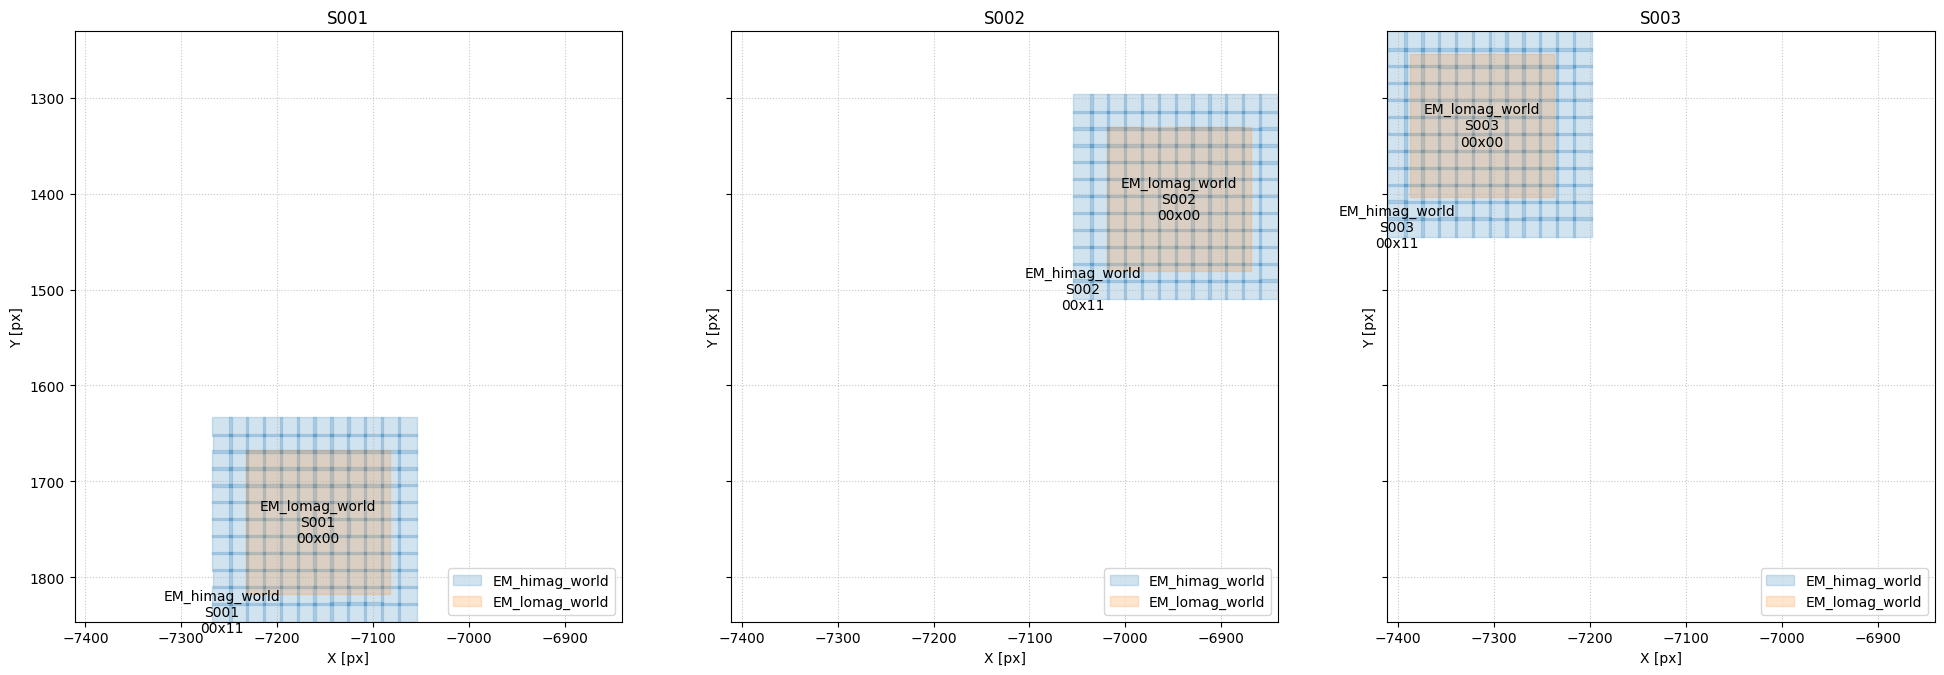

In [9]:
# Set stacks to plot
stacks_2_plot = [stack for stack in stacks if 'world' in stack]

# Plot tile map
plot_tile_map(stacks_2_plot, render=render)